In [ ]:
!pip install fasttext
!pip install joblib
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install keras tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313501 sha256=98e0473a24e9bab40387c5a7b7bbc6fd459f0b6eb88a6cf1abf3e5ca36c0a49d
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
import os
import pandas as pd
import numpy as np
import fasttext
import fasttext.util
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
)

from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
fasttext.util.download_model('pl', if_exists='ignore')

'cc.pl.300.bin'

In [5]:
ft_model = fasttext.load_model('cc.pl.300.bin')

In [ ]:
def get_sequence_ft_vectors(text, max_len=50):
    words = text_to_word_sequence(str(text), lower=False)
    vectors = [ft_model.get_word_vector(word) for word in words[:max_len]]
    return vectors

In [ ]:
def prepare_sequence_data_with_category(data_path, max_len=50):
    df = pd.read_csv(data_path)
    df = df.dropna()

    X = [get_sequence_ft_vectors(text, max_len=max_len) for text in df['text']]
    y = df['label'].values
    categories = df['category'].values

    X_pad = pad_sequences(X, maxlen=max_len, dtype='float32', padding='post', truncating='post')

    return X_pad, y, categories

In [ ]:
def evaluate_lstm_model(model_path, X, y, categories, model_title):
    model = load_model(model_path)
    y_proba = model.predict(X)
    y_pred = np.argmax(y_proba, axis=1) if y_proba.shape[1] > 1 else (y_proba > 0.5).astype(int).flatten()

    print(f"\n=== {model_title} (Extreme Cases) ===")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred, average='macro'))
    print("Recall:", recall_score(y, y_pred, average='macro'))
    print("F1-score:", f1_score(y, y_pred, average='macro'))

    if len(np.unique(y)) == 2:
      if y_proba.ndim == 2 and y_proba.shape[1] > 1:
          roc_auc = roc_auc_score(y, y_proba[:, 1])
          proba_for_roc = y_proba[:, 1]
      else:
          roc_auc = roc_auc_score(y, y_proba)
          proba_for_roc = y_proba

    print("ROC-AUC:", roc_auc)

    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix for LSTM - Raw Data Extreme Cases Dataset")
    plt.show()

    fpr, tpr, _ = roc_curve(y, proba_for_roc)
    plt.figure()
    plt.plot(fpr, tpr, label=f"(AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for LSTM - Raw Data Extreme Cases Dataset")
    plt.legend()
    plt.grid()
    plt.show()

    correct_mask = y_pred == y
    correct_categories = categories[correct_mask]

    unique_cats = sorted(np.unique(categories))
    counts = [np.sum(correct_categories == cat) for cat in unique_cats]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=unique_cats, y=counts, palette="magma")
    plt.xlabel("Case Category (1–6)")
    plt.ylabel("Correct Predictions")
    plt.title("Correct Predictions per Category for LSTM Model")
    plt.grid(True, axis='y')
    plt.xticks(ticks=range(len(unique_cats)), labels=[str(c) for c in unique_cats])

    for i, count in enumerate(counts):
        plt.text(i, count + 0.2, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.show()

    print("\n--- Summary of Correct Predictions per Category ---")
    for cat in unique_cats:
        total = np.sum(categories == cat)
        correct = np.sum((categories == cat) & (y_pred == y))
        print(f"Kategoria {cat}: poprawnie {correct} na {total}")

In [ ]:
X_lstm_raw, y_lstm_raw, cat_lstm_raw = prepare_sequence_data_with_category("extreme_examples_raw.csv")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step

=== LSTM - Raw Data (Extreme Cases) ===
Accuracy: 0.2988505747126437
Precision: 0.33457556935817806
Recall: 0.3089430894308943
F1-score: 0.29126602564102566
ROC-AUC: 0.24581539933046387


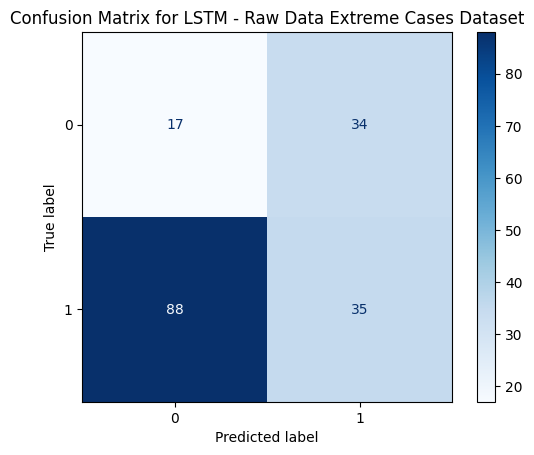

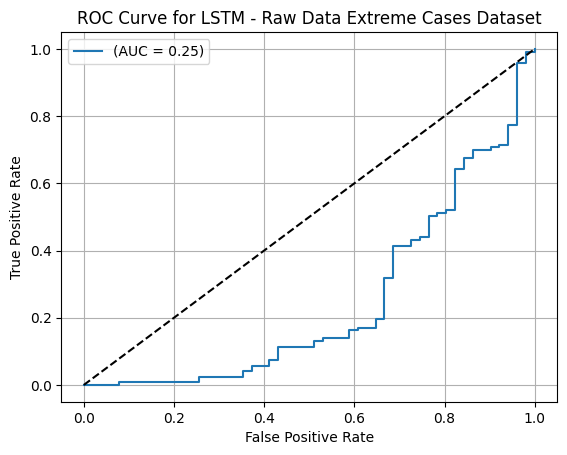

<ipython-input-31-fbb4126c451d>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_cats, y=counts, palette="magma")


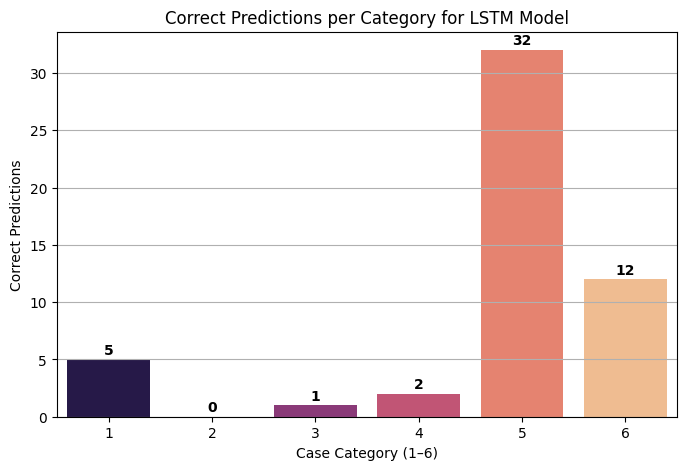


--- Summary of Correct Predictions per Category ---
Kategoria 1: poprawnie 5 na 24
Kategoria 2: poprawnie 0 na 25
Kategoria 3: poprawnie 1 na 25
Kategoria 4: poprawnie 2 na 25
Kategoria 5: poprawnie 32 na 50
Kategoria 6: poprawnie 12 na 25


In [ ]:
evaluate_lstm_model("LSTM_model.h5", X_lstm_raw, y_lstm_raw, cat_lstm_raw, "LSTM - Raw Data")